In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_8132/255713361.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
# Define the URL from which the data will be imported.

data = pd.read_csv(url, sep=';')
# Use pandas to read the data from the specified URL, assuming the data is separated by semicolons.

data = data[data['total sulfur dioxide'] < 200]
# Filter the data to remove rows where the 'total sulfur dioxide' column value is less than 200.
# This step is intended to drop a few outliers from the dataset.

# z-score all columns except for quality
cols2zscore = data.keys()
# Get the column names (features) of the 'data' DataFrame and store them in the 'cols2zscore' variable.

cols2zscore = cols2zscore.drop('quality')
# Remove the 'quality' column name from the 'cols2zscore' variable. The 'quality' column likely represents the target variable.

data[cols2zscore] = data[cols2zscore].apply(stats.zscore)
# Calculate the z-scores for all columns listed in 'cols2zscore' (except 'quality') and update the 'data' DataFrame with the standardized values.
# This step standardizes (centers and scales) the numerical columns so that they have a mean of 0 and a standard deviation of 1.

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# Add a new column named 'boolQuality' to the 'data' DataFrame and initialize it with zeros.

# data['boolQuality'][data['quality'] < 6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality'] > 5] = 1
# Assign a value of 1 to the 'boolQuality' column for rows where the 'quality' column value is greater than 5.
# This step creates a binary representation of wine quality where 1 indicates "good" quality (quality > 5) and 0 indicates "not good" quality (quality <= 5).


/tmp/ipykernel_8132/3668872412.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality'] > 5] = 1
/tmp/ipykernel_8132/3668872412.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

# Re-organize the data: train/test in DataLoaders

In [3]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
# Convert the selected columns of the 'data' DataFrame to a PyTorch tensor.
# - `data[cols2zscore]` extracts the columns specified in 'cols2zscore'.
# - `.values` converts the selected DataFrame columns to a numpy array.
# - `torch.tensor(...)` converts the numpy array to a PyTorch tensor.
# - `.float()` ensures that the tensor contains floating-point values.

labels = torch.tensor( data['boolQuality'].values ).float()
# Convert the 'boolQuality' column of the 'data' DataFrame to a PyTorch tensor.
# - `data['boolQuality']` extracts the 'boolQuality' column.
# - `.values` converts the selected DataFrame column to a numpy array.
# - `torch.tensor(...)` converts the numpy array to a PyTorch tensor.
# - `.float()` ensures that the tensor contains floating-point values.

labels = labels[:, None]
# Reshape the 'labels' tensor to be a matrix with a single column.
# This transformation is often necessary to match the shape expected by machine learning models.


In [4]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)

# Now for the DL part

In [5]:
# create a class for the model WITH BATCH NORM

class ANNwine_withBNorm(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    # Define the input layer with 11 input features and 16 output units (neurons).

    ### hidden layers
    self.fc1    = nn.Linear(16,32)
    # Define the first hidden layer with 16 input units and 32 output units.
    self.bnorm1 = nn.BatchNorm1d(16)
    # Apply Batch Normalization to the output of the first hidden layer.
    self.fc2    = nn.Linear(32,20)
    # Define the second hidden layer with 32 input units and 20 output units.
    self.bnorm2 = nn.BatchNorm1d(32)
    # Apply Batch Normalization to the output of the second hidden layer.

    ### output layer
    self.output = nn.Linear(20,1)
    # Define the output layer with 20 input units and 1 output unit (for regression).
  
  # forward pass
  def forward(self,x,doBN):

    # input (x starts off normalized)
    x = F.relu( self.input(x) )
    # Apply the ReLU activation function to the output of the input layer.

    if doBN:
      # If 'doBN' is True, apply Batch Normalization to the hidden layers.

      # hidden layer 1
      x = self.bnorm1(x) # batchnorm
      # Apply Batch Normalization to the output of the first hidden layer.
      x = self.fc1(x)    # weighted combination
      # Compute the weighted combination (linear transformation) of the first hidden layer.
      x = F.relu(x)      # activation function
      # Apply the ReLU activation function.

      # hidden layer 2
      x = self.bnorm2(x) # batchnorm
      # Apply Batch Normalization to the output of the second hidden layer.
      x = self.fc2(x)    # weighted combination
      # Compute the weighted combination (linear transformation) of the second hidden layer.
      x = F.relu(x)      # activation function
      # Apply the ReLU activation function.
    
    else:
      # If 'doBN' is False, skip Batch Normalization and apply ReLU directly to hidden layers.

      # hidden layer 1
      x = F.relu( self.fc1(x) )
      # Compute the weighted combination (linear transformation) of the first hidden layer and apply ReLU.

      # hidden layer 2
      x = F.relu( self.fc2(x) )
      # Compute the weighted combination (linear transformation) of the second hidden layer and apply ReLU.

    # output layer
    return self.output(x)
    # Compute the output of the model by applying the linear transformation of the output layer.


# Train the model

In [6]:
# a function that trains the model

# global parameter
numepochs = 1000
# Set the number of training epochs to 1000. This defines how many times the entire training dataset is used for training.

def trainTheModel(doBN=True):
  # Define a function 'trainTheModel' that trains the neural network model.

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  # Define the loss function as Binary Cross-Entropy Loss with Logits.
  optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)
  # Define the optimizer as Stochastic Gradient Descent (SGD) with a learning rate of 0.01.
  # The optimizer operates on the parameters of the 'winenet' model.

  # initialize losses
  losses   = torch.zeros(numepochs)
  # Initialize a tensor 'losses' to store losses for each epoch.
  trainAcc = []
  testAcc  = []
  # Initialize empty lists 'trainAcc' and 'testAcc' to store training and testing accuracies.

  # loop over epochs
  for epochi in range(numepochs):
    # Iterate over the specified number of training epochs.

    # switch on training mode
    winenet.train()
    # Set the 'winenet' model to training mode. This is important for layers like Batch Normalization.

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    # Initialize lists 'batchAcc' and 'batchLoss' to store accuracy and loss for each mini-batch.

    for X, y in train_loader:
      # Iterate over mini-batches of training data.

      # forward pass and loss
      yHat = winenet(X, doBN)
      # Perform a forward pass through the neural network ('winenet') with an option to apply Batch Normalization ('doBN').
      loss = lossfun(yHat, y)
      # Calculate the loss by comparing the predicted values ('yHat') with the true labels ('y').

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Perform backpropagation to update the model's parameters based on the computed gradients.

      # loss from this batch
      batchLoss.append(loss.item())
      # Append the loss for this mini-batch to the 'batchLoss' list.

      # compute training accuracy for this batch
      batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
      # Calculate the training accuracy for this mini-batch, indicating the percentage of correctly predicted labels.

    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append(np.mean(batchAcc))
    # Calculate and store the average training accuracy across all mini-batches for this epoch.

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)
    # Calculate and store the average loss across all mini-batches for this epoch.

    ### test accuracy
    winenet.eval()
    # Set the 'winenet' model to evaluation mode, which disables certain operations like dropout.

    X, y = next(iter(test_loader))
    # Extract a mini-batch of testing data and labels for evaluation.

    with torch.no_grad():
      # Use 'torch.no_grad()' to deactivate autograd (no gradient computation) for evaluation.
      yHat = winenet(X, doBN)
      # Get predictions for the testing data using the trained model.

    testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
    # Calculate and store the testing accuracy for this epoch.
    # - `yHat > 0` checks if the predicted labels are greater than 0.
    # - `torch.mean(...).item()` calculates the accuracy as a percentage.

  # function output
  return trainAcc, testAcc, losses
  # Return the training accuracies, testing accuracies, and losses as output from the training function.


# Now for the experiment

In [7]:
# takes ~2 mins

# create and train a model NO BATCHNORM
winenet = ANNwine_withBNorm()
trainAccNo,testAccNo,lossesNo = trainTheModel(False)

# create and train a model WITH BATCHNORM
winenet = ANNwine_withBNorm()
trainAccWith,testAccWith,lossesWith = trainTheModel(True)


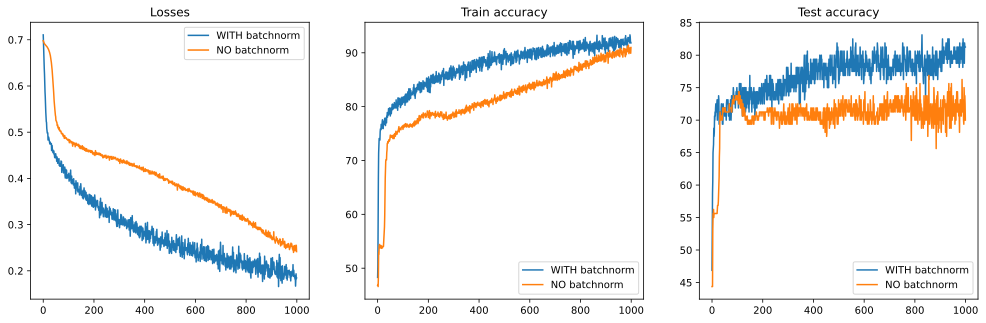

In [8]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(lossesWith,label='WITH batchnorm')
ax[0].plot(lossesNo,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAccWith,label='WITH batchnorm')
ax[1].plot(trainAccNo,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAccWith,label='WITH batchnorm')
ax[2].plot(testAccNo,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()

# Additional explorations